<a href="https://colab.research.google.com/github/mtzig/LIDC_GDRO/blob/main/notebooks/LIDC_Georges_End_to_End.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LIDC GDRO: Looking at Clustered Subgroups

Thomas Zeng

## Notebook Setup

Setup autoreload extension

In [1]:
%load_ext autoreload
%autoreload 2

Clone repo (if on colab)

In [2]:
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd /content/LIDC_GDRO
# %cd ..

Cloning into 'LIDC_GDRO'...
remote: Enumerating objects: 3688, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 3688 (delta 152), reused 258 (delta 152), pack-reused 3428
Receiving objects: 100% (3688/3688), 81.77 MiB | 3.61 MiB/s, done.
Resolving deltas: 100% (3300/3300), done.
Checking out files: 100% (5414/5414), done.
/content/LIDC_GDRO


In [77]:
# !git pull

remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 6 (delta 4), reused 6 (delta 4), pack-reused 0
Unpacking objects: 100% (6/6), done.
From https://github.com/mtzig/LIDC_GDRO
   46b0982..0c10c05  main       -> origin/main
Updating 46b0982..0c10c05
Fast-forward
 data/LIDC_data_split.csv | 2862 +++++++++++++++++++++++-----------------------
 scripts/split_data.py    |    2 +-
 2 files changed, 1432 insertions(+), 1432 deletions(-)


import necessary libraries

In [9]:
# !pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 2.4 MB/s 
     |████████████████████████████████| 1.1 MB 53.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=64703330d665a7149644a32f268f672595c4b2a9d74096365297756d95e1de46
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=287b42d12502e9b1861f7f79f04a2fdacc1a4b0d2c35101c9b54fdfbbfaeff7e
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [75]:
import pandas as pd
import numpy as np
from dataloaders import InfiniteDataLoader
from datasets import NoduleDataset, SubclassedNoduleDataset
from models import TransferModel
from train import train, test
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
# import torchvision
from torchvision import transforms
import torch
from image_data_utils import getImages, train_epochs, show_scatter

from umap import UMAP
# from matplotlib import pyplot as plt
import pickle
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

Get available Device

In [11]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Using cpu")
    DEVICE = torch.device("cpu")

Good to go!


## ERM Model: Training ERM model to extract CNN features

### ERM Modeling

Just for visulalization, the csv where we get the train, cv, test splits and subgroups come from below csv. 

In [78]:
df_splits = pd.read_csv('./data/LIDC_data_split.csv', index_col=0)
df_splits.head()

,noduleID,spiculation,malignancy,malignancy_b,split
1295,1,6,3,1,0
1400,2,7,3,1,0
1435,3,6,3,1,1
1066,4,4,2,1,0
1244,5,4,2,1,2


First we load in the training data

In [79]:
train_data, cv_data, test_data = getImages(split=True, sublabels='malignancy', binary=True, device=DEVICE)

#datasets
tr = SubclassedNoduleDataset(*train_data)
cv = SubclassedNoduleDataset(*cv_data)
tst = SubclassedNoduleDataset(*test_data)

#dataloaders
tr_loader = InfiniteDataLoader(tr, batch_size=512)
cv_loader = InfiniteDataLoader(cv, len(cv))
tst_loader = InfiniteDataLoader(tst, len(tst))

Next we initialize the model!

In [80]:
model = TransferModel(device=DEVICE, pretrained=True, freeze=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Now we train the model

In [81]:
epochs = 15
train_epochs(epochs, tr_loader, cv_loader, model, loss_fn='ERM',scheduler=True, verbose=False)

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 2.0000e-05.
Epoch 14/15
Epoch 15/15


In [82]:
test(tst_loader,model)

(0.840531561461794,
 0.859375,
 0.8203125,
 0.7666666666666667,
 0.9591836734693877)

### Feature Extraction

We first save model weights (for reproducibility)

In [83]:
 torch.save(model.state_dict(), './data/erm_cluster_weights.pt')

Next we add hooks to let us get activations

In [84]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.model.avgpool.register_forward_hook(get_activation('avgpool'))

We re get the data, but in its entirety with the noduleID

In [85]:
noduleID, data = getImages(split=False, binary=True, device=DEVICE)

Now we extract features

In [86]:
imgs = torch.stack(data[0])
model(imgs)
img_features = activation['avgpool'].squeeze()

We collect all the features in a dataframe

In [87]:
cols = []
for idx,id in enumerate(noduleID):
  cols.append([id] + img_features[idx].cpu().numpy().tolist())
df_features = pd.DataFrame(cols).rename({0:'noduleID'}, axis=1)

splits = [df_splits[df_splits['noduleID'] == id]['split'].iloc[0] for id in  df_features['noduleID']]
malig = [df_splits[df_splits['noduleID'] == id]['malignancy'].iloc[0] for id in  df_features['noduleID']]

df_features['split'] = splits
df_features['malignancy'] = malig
df_features['malignancy_b'] = np.where(df_features['malignancy']>1, 1, 0)
df_features.head()

,noduleID,1,2,3,4,5,6,7,8,9,...,506,507,508,509,510,511,512,split,malignancy,malignancy_b
0,256,0.183260,4.312293,2.059173,1.432487,2.350920,0.647984,2.891989,0.049920,0.0,...,0.191236,3.239036,0.075778,3.152098,0.343085,1.293521,2.136414,0,0,0
1,2341,0.000000,1.142348,0.753448,0.000000,0.487864,0.005272,0.001798,0.320833,0.0,...,0.004423,1.941060,0.435997,0.140607,0.070576,1.773903,0.226160,0,0,0
2,2114,0.000000,0.073909,1.830737,0.037947,1.338974,0.027540,0.263370,0.016433,0.0,...,0.135668,1.639892,0.820040,2.263094,0.000000,1.471433,0.105198,0,0,0
3,1667,0.133601,3.408651,1.613973,1.630779,1.899988,0.000000,4.386237,0.000000,0.0,...,0.000000,2.334527,1.956937,2.828119,0.000000,1.106740,1.117126,0,0,0
4,2274,0.860467,2.001873,1.481265,1.691173,0.955317,0.022374,2.567112,0.072856,0.0,...,0.206975,1.141855,4.035005,1.422811,0.000000,1.221407,0.737359,0,0,0


We again save the data for reproducibility

In [88]:
df_features.to_csv('./data/erm_cluster_cnn_features.csv')

## Feature Reduce and Cluster

### Feature Reduce

First we split df into two by the splits

In [89]:
df_features_train = df_features[df_features['split'] == 0]
df_features_cv_test = df_features[df_features['split'] != 0]

Next we get the features in an array

In [90]:
train_features = df_features_train.drop(['noduleID', 'split', 'malignancy', 'malignancy_b'], axis=1).values
cv_test_features = df_features_cv_test.drop(['noduleID', 'split', 'malignancy', 'malignancy_b'], axis=1).values

Following the George paper, we use UMAP to dimensionaly reduce our data

In [91]:
reducer = UMAP(random_state=8)
reducer.fit(train_features)

UMAP(random_state=8, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [92]:
train_embeds = reducer.transform(train_features)

Now we visualize the reduction on train dataset

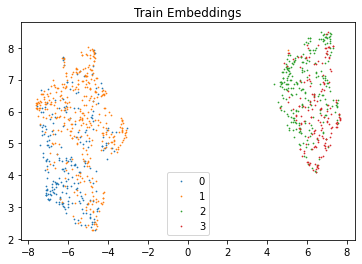

In [93]:
show_scatter(train_embeds[:, 0], train_embeds[:, 1],df_features_train['malignancy'],'Train Embeddings', 0.5)



We also do same visualization on cv and test

In [94]:
cv_test_embeds = reducer.transform(cv_test_features)

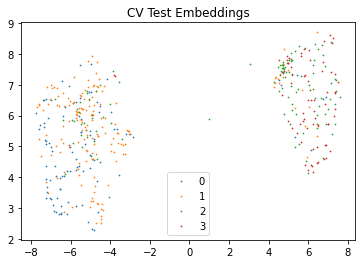

In [95]:
show_scatter(cv_test_embeds[:, 0], cv_test_embeds[:, 1],df_features_cv_test['malignancy'],'CV Test Embeddings', 0.5)


We now save the reduce

In [96]:
f_reducer = './cnn_umap_reducer.sav'
pickle.dump(reducer, open(f_reducer, 'wb'))




Note to lode from above file, we can call
```python
reducer = pickle.load((open(f_reducer, 'rb'))) 
```

### Feature Cluster

Now we cluster the training embeddings using Gaussian Mixture

We first visualize the silhouette score

(we only cluster on malignant since that is what we want)

In [97]:
train_embeds_malig = reducer.transform(train_features[df_features_train['malignancy_b'] == 1])

Text(0, 0.5, 'Silhouette Coefficients')

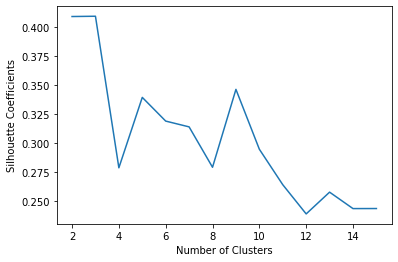

In [98]:
clusters = [n for n in range(2,16)]
silhouette_coefficients = []

for cluster in clusters:
  gmm = GaussianMixture(n_components=cluster, random_state=61).fit(train_embeds_malig)
  labels = gmm.predict(train_embeds_malig)
  
  silhouette_avg = silhouette_score(train_embeds_malig, labels)
  silhouette_coefficients.append(silhouette_avg)

plt.plot(clusters, silhouette_coefficients)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficients')

We note from above, the best number of subclasses is 2.

In [99]:
clusterer = GaussianMixture(n_components=2, random_state=61).fit(train_embeds_malig)

We now visualize the clusters ont train

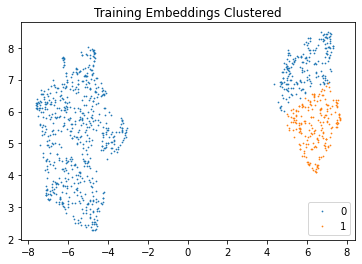

In [100]:
train_labels = clusterer.predict(train_embeds)

show_scatter(train_embeds[:, 0], train_embeds[:, 1],train_labels,'Training Embeddings Clustered', 0.5)

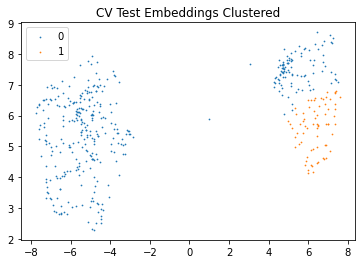

In [101]:
cv_test_labels = clusterer.predict(cv_test_embeds)

show_scatter(cv_test_embeds[:, 0], cv_test_embeds[:, 1],cv_test_labels,'CV Test Embeddings Clustered', 0.5)

Now we save the clusterer

In [102]:
f_clusterer = './cnn_umap_clusterer.sav'
pickle.dump(reducer, open(f_reducer, 'wb'))

### Save the labels

Now that we have the labels, we want to save them to csv we so we can train gDRO on them

In [103]:
df_features_train['clusters'] = train_labels
df_features_cv_test['clusters'] = cv_test_labels

df_clusters = pd.concat([df_features_train, df_features_cv_test])[['noduleID', 'clusters']]
df_clusters.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,noduleID,clusters
0,256,0
1,2341,0
2,2114,0
3,1667,0
4,2274,0


In [104]:
df_clusters = df_clusters.sort_values('noduleID')

We can add these lables to the df_splits dataframe

In [105]:
df_splits['malignancy_b'] = np.where(df_splits['malignancy']>1, 1, 0)

In [106]:
df_splits['clusters'] = [m + c for m,c in zip(df_splits['malignancy_b'], df_clusters['clusters'])]

In [107]:
df_splits['clusters']

1295    1
1400    1
1435    2
1066    1
1244    1
       ..
1028    1
819     0
707     0
1436    1
501     0
Name: clusters, Length: 1488, dtype: int64

Now we save the csv

In [111]:
df_splits.to_csv('./data/LIDC_data_split.csv')

## Train ERM and gDRO on new models

We again get our dataloaders (but with the new sublables)

In [113]:
df_splits = pd.read_csv('./data/LIDC_data_split.csv', index_col=0)
df_splits.head()

,noduleID,1,2,3,4,5,6,7,8,9,...,506,507,508,509,510,511,512,split,malignancy,malignancy_b
0,256,0.183260,4.312293,2.059173,1.432487,2.350920,0.647984,2.891989,0.049920,0.0,...,0.191236,3.239036,0.075778,3.152098,0.343085,1.293521,2.136414,0,0,0
1,2341,0.000000,1.142348,0.753448,0.000000,0.487864,0.005272,0.001798,0.320833,0.0,...,0.004423,1.941060,0.435997,0.140607,0.070576,1.773903,0.226160,0,0,0
2,2114,0.000000,0.073909,1.830737,0.037947,1.338974,0.027540,0.263370,0.016433,0.0,...,0.135668,1.639892,0.820040,2.263094,0.000000,1.471433,0.105198,0,0,0
3,1667,0.133601,3.408651,1.613973,1.630779,1.899988,0.000000,4.386237,0.000000,0.0,...,0.000000,2.334527,1.956937,2.828119,0.000000,1.106740,1.117126,0,0,0
4,2274,0.860467,2.001873,1.481265,1.691173,0.955317,0.022374,2.567112,0.072856,0.0,...,0.206975,1.141855,4.035005,1.422811,0.000000,1.221407,0.737359,0,0,0


In [112]:
train_data, cv_data, test_data = getImages(split=True, sublabels='clusters', binary=True, device=DEVICE)

#datasets
tr = SubclassedNoduleDataset(*train_data)
cv = SubclassedNoduleDataset(*cv_data)
tst = SubclassedNoduleDataset(*test_data)

#dataloaders
tr_loader = InfiniteDataLoader(tr, batch_size=512)
cv_loader = InfiniteDataLoader(cv, len(cv))
tst_loader = InfiniteDataLoader(tst, len(tst))

KeyError: ignored